## Prepare Notebook

In [1]:
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from pymc import do

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "fixed_random"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generate Data

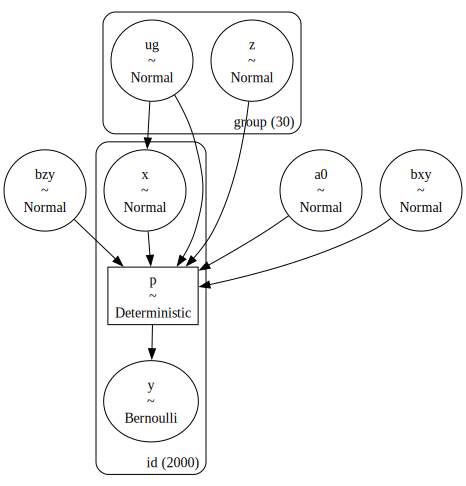

In [3]:
n_groups: int = 30
n_id: int = 2_000
g = rng.choice(n_groups, size=(n_id,), replace=True)

coords: dict[str, Any] = {
    "group": np.arange(n_groups),
    "id": np.arange(n_id),
}

with pm.Model(coords=coords) as generative_model:
    a0 = pm.Normal("a0", mu=0, sigma=1)
    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)
    ug = pm.Normal("ug", mu=0, sigma=1.5, dims="group")
    x = pm.Normal("x", mu=ug[g], sigma=1, dims="id")
    z = pm.Normal("z", mu=0, sigma=1, dims="group")
    p = pm.Deterministic(
        "p", pm.math.invlogit(a0 + bxy * x + ug[g] + bzy * z[g]), dims="id"
    )
    pm.Bernoulli("y", p, dims="id")


pm.model_to_graphviz(generative_model)

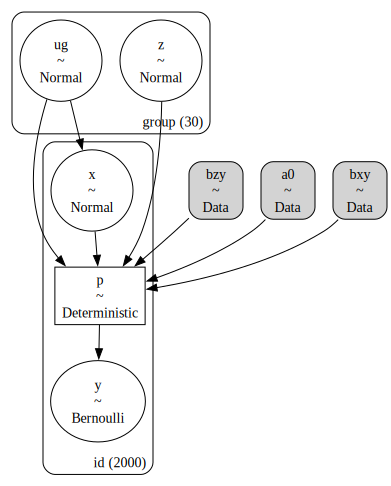

In [4]:
true_params = {"a0": -2, "bzy": 1.0, "bxy": 0.0}

generative_model_do = do(generative_model, true_params)

pm.model_to_graphviz(generative_model_do)

In [5]:
with generative_model_do:
    idata_obs = pm.sample_prior_predictive(draws=1)

Sampling: [ug, x, y, z]


In [6]:
ug_obs = idata_obs["prior"]["ug"].sel(chain=0, draw=0).to_numpy()
z_obs = idata_obs["prior"]["z"].sel(chain=0, draw=0).to_numpy()
x_obs = idata_obs["prior"]["x"].sel(chain=0, draw=0).to_numpy()
y_obs = idata_obs["prior"]["y"].sel(chain=0, draw=0).to_numpy()

assert ug_obs.shape == (n_groups,)
assert z_obs.shape == (n_groups,)
assert x_obs.shape == (n_id,)
assert y_obs.shape == (n_id,)

data_df = pd.DataFrame(
    {"group": g, "x": x_obs, "y": y_obs, "z": z_obs[g], "ug": ug_obs[g]}
)

data_df.head()

,group,x,y,z,ug
0,29,-0.493169,1,1.211396,0.562365
1,28,-0.384867,0,0.076701,0.536027
2,28,1.248865,0,0.076701,0.536027
3,5,0.948384,1,1.591187,0.526377
4,28,0.064316,0,0.076701,0.536027


## Exploratory Data Analysis

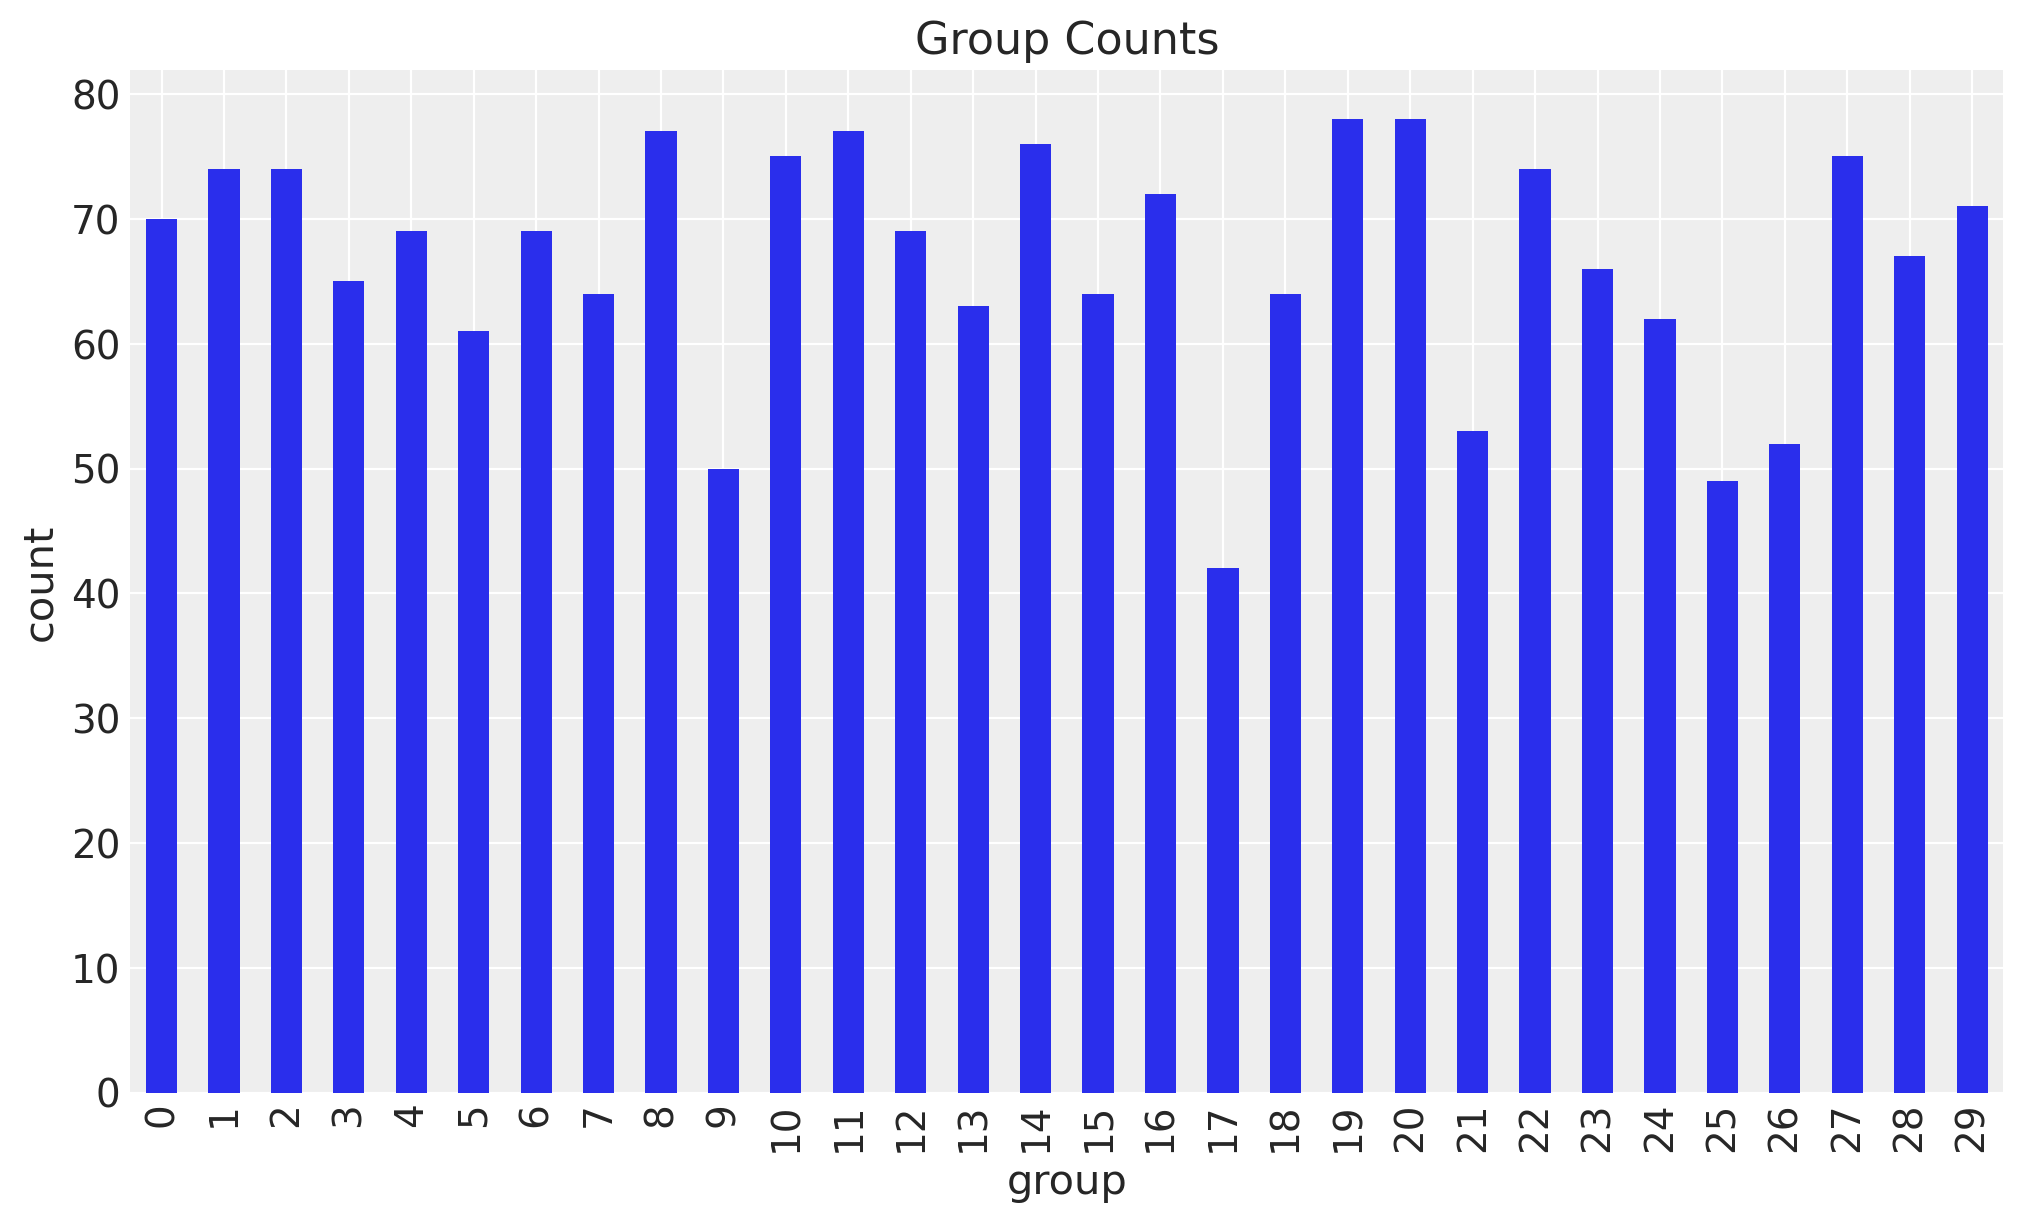

In [7]:
fig, ax = plt.subplots()

data_df.value_counts("group").sort_index().plot.bar(ax=ax)
ax.set(xlabel="group", ylabel="count", title="Group Counts");

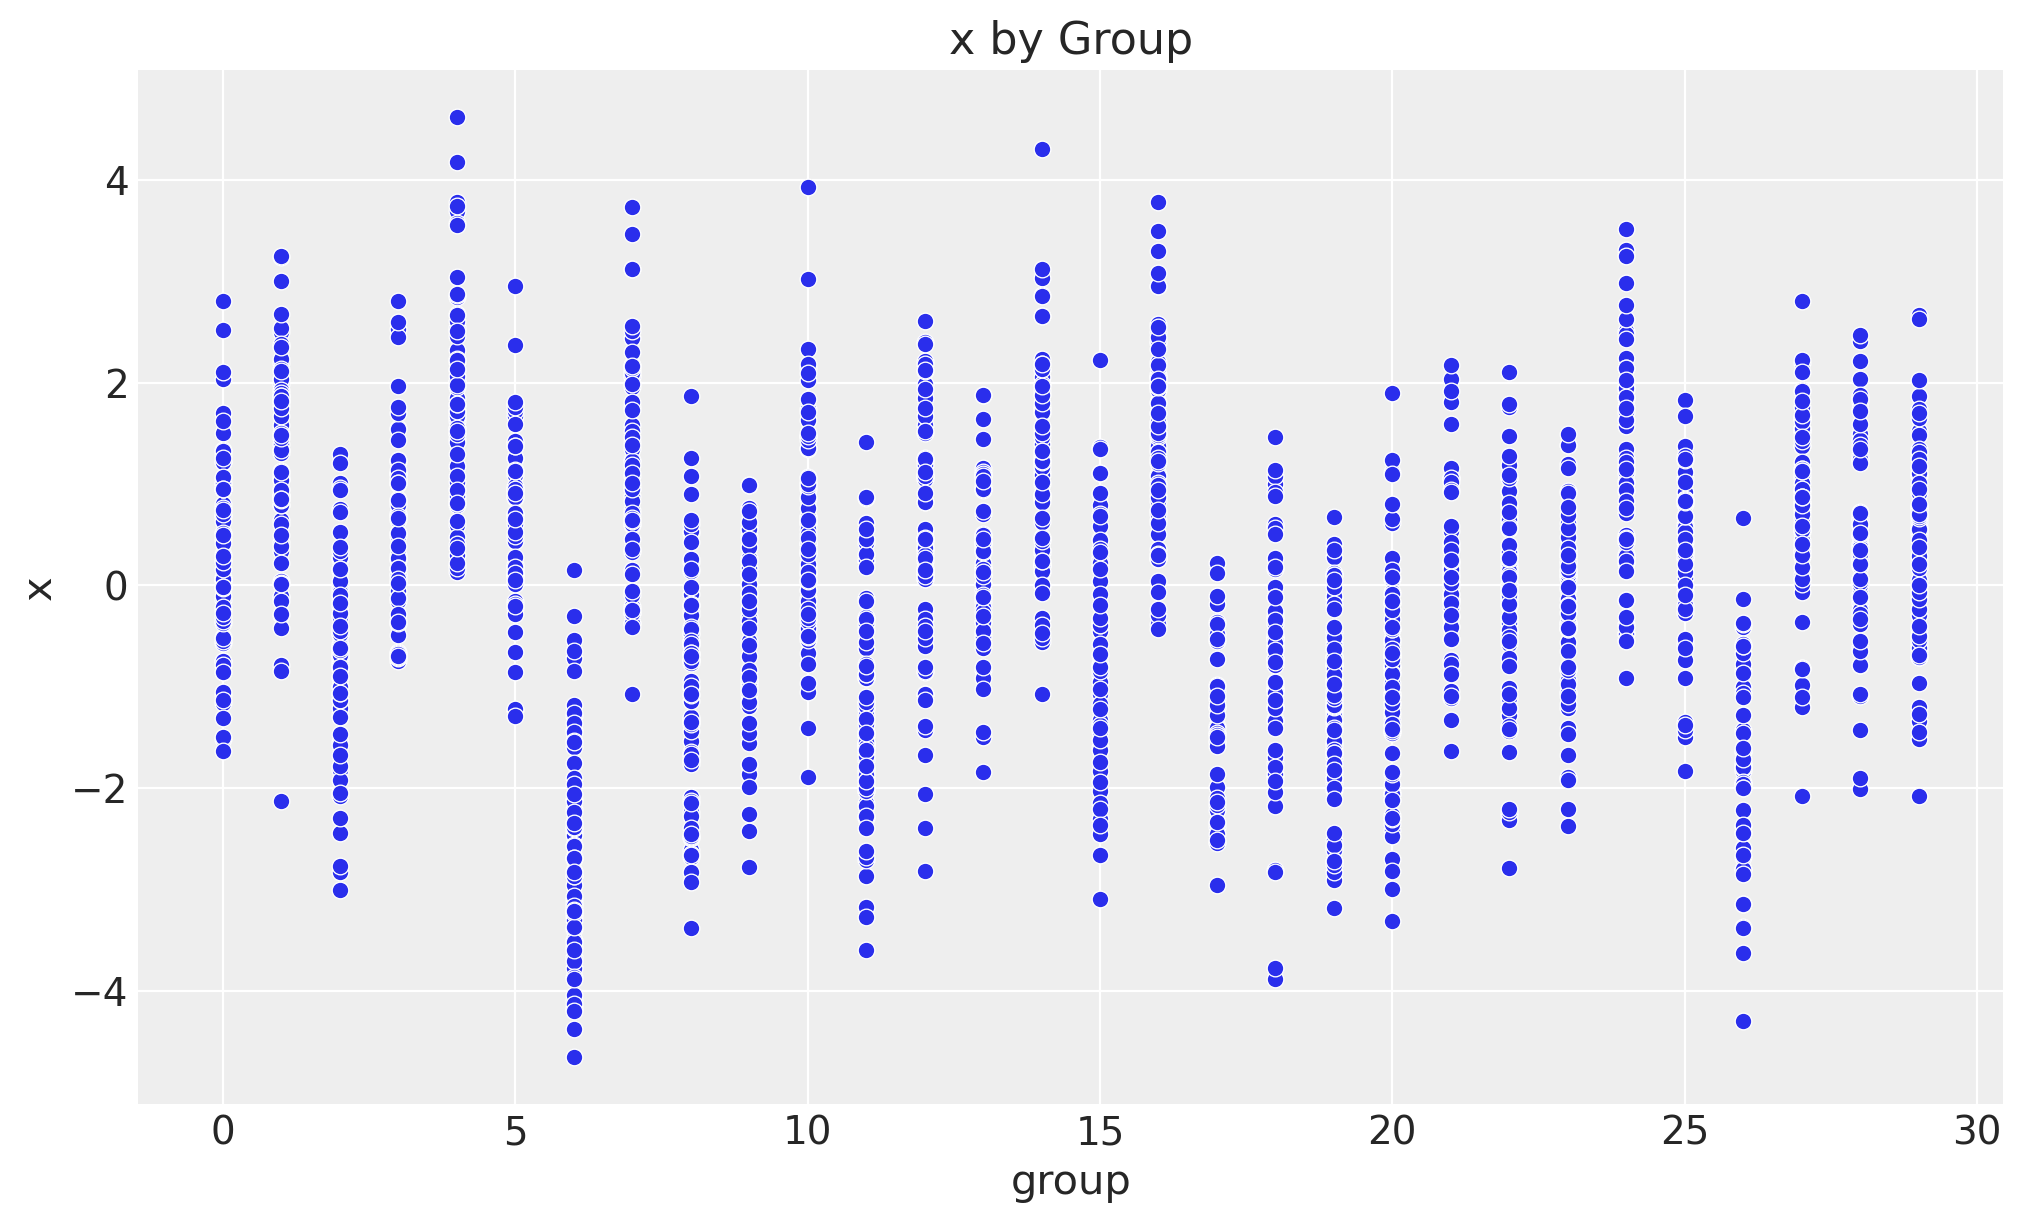

In [8]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="group", y="x", ax=ax)
ax.set(xlabel="group", ylabel="x", title="x by Group");

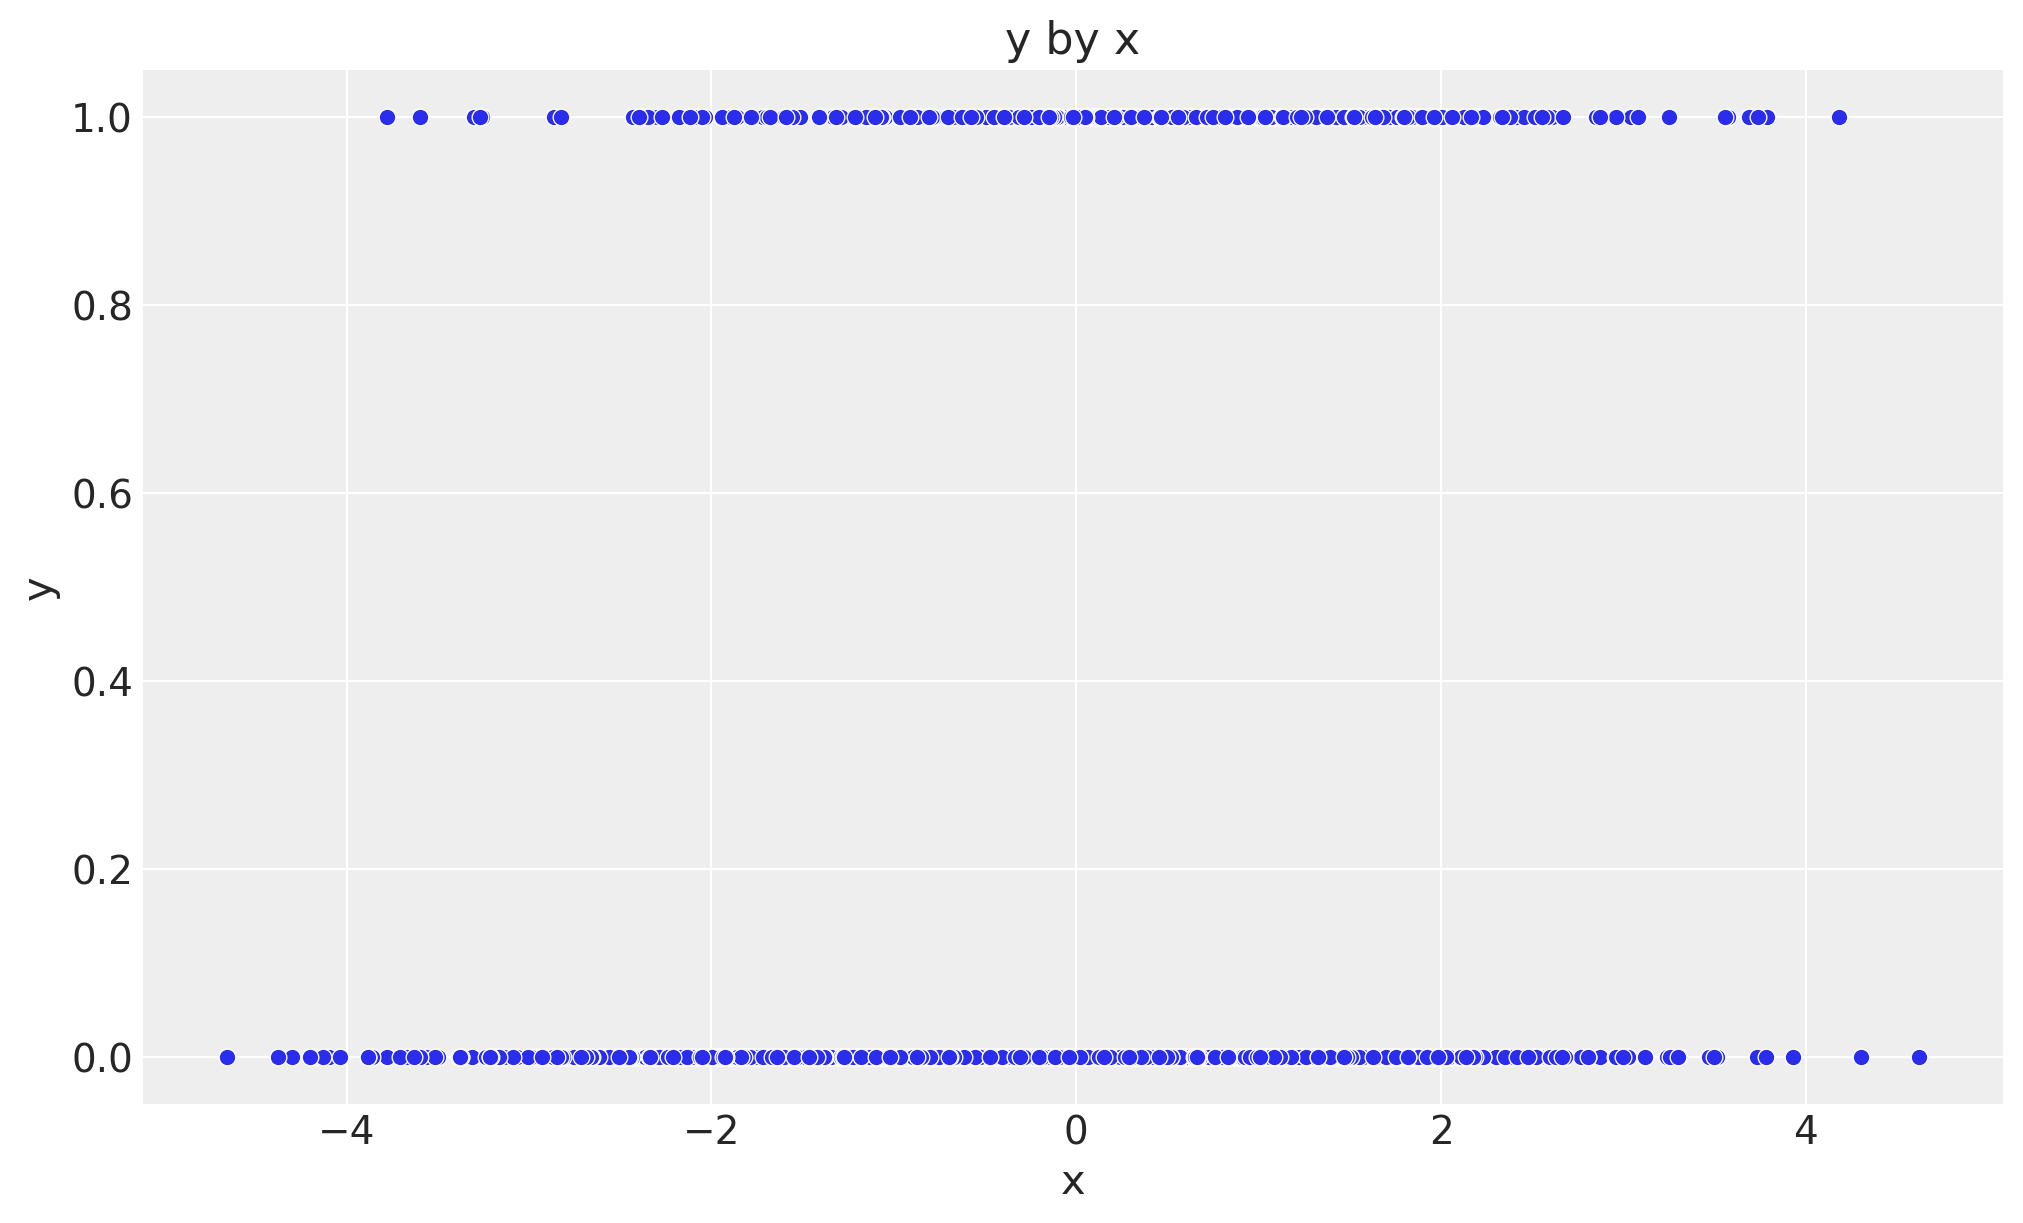

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="x", y="y", ax=ax)
ax.set(xlabel="x", ylabel="y", title="y by x");

## Naive Model

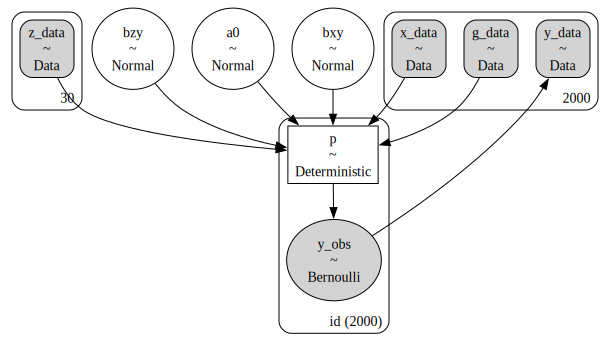

In [10]:
with pm.Model(coords=coords) as naive_model:
    x_data = pm.Data("x_data", x_obs)
    y_data = pm.Data("y_data", y_obs)
    g_data = pm.Data("g_data", g)
    z_data = pm.Data("z_data", z_obs)

    a0 = pm.Normal("a0", mu=0, sigma=1)
    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)

    p = pm.Deterministic(
        "p", pm.math.invlogit(a0 + bxy * x_data + bzy * z_data[g_data]), dims="id"
    )
    pm.Bernoulli("y_obs", p, dims="id", observed=y_data)

pm.model_to_graphviz(naive_model)

In [ ]:
with naive_model:
    idata_naive = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        cores=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.92,3
,2000,0,0.96,7
,2000,0,0.86,7
,2000,0,0.98,1


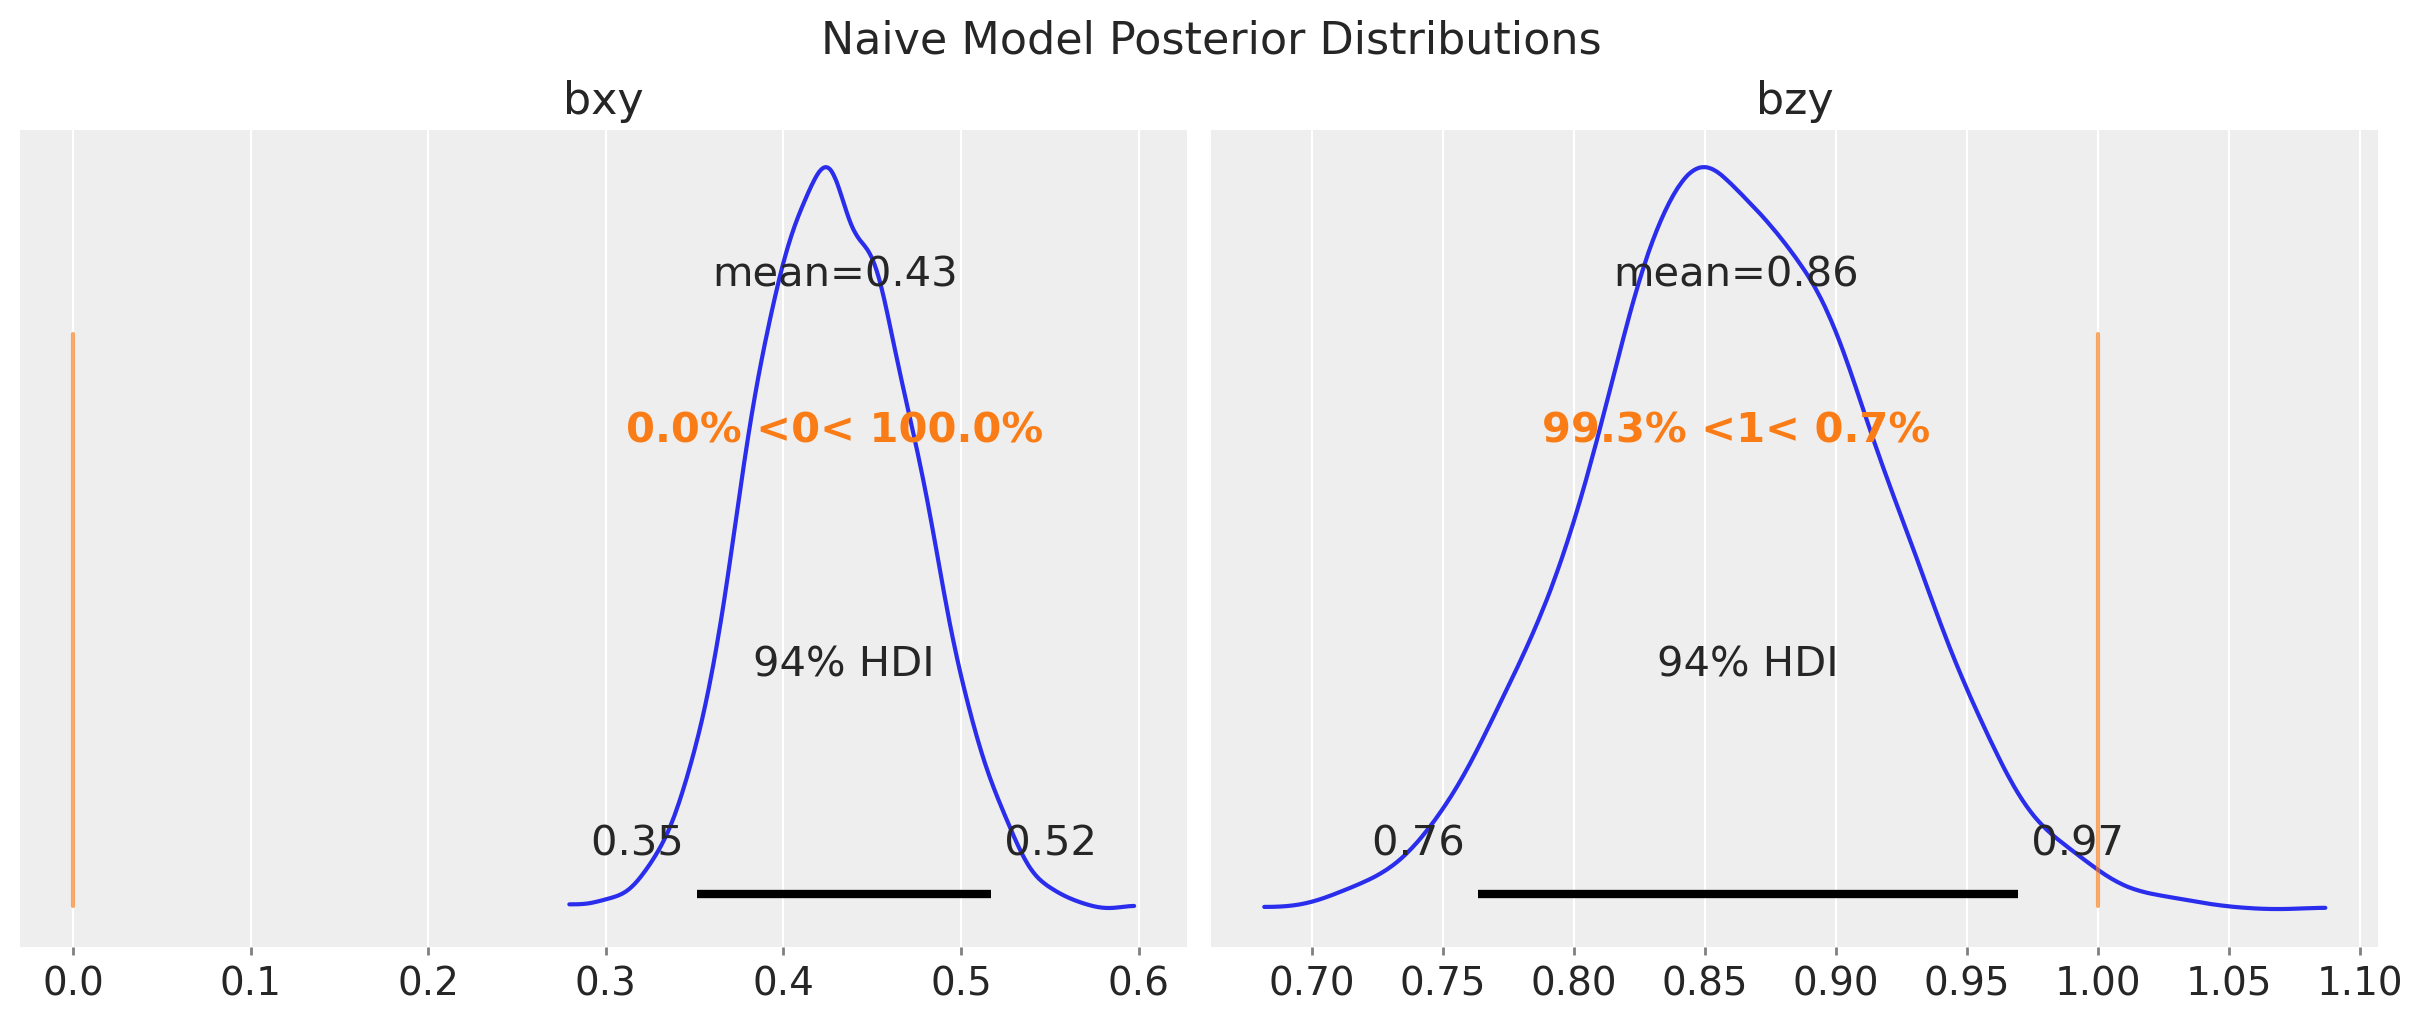

In [ ]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Naive Model Posterior Distributions", fontsize=16);

## Fixed Effects Model

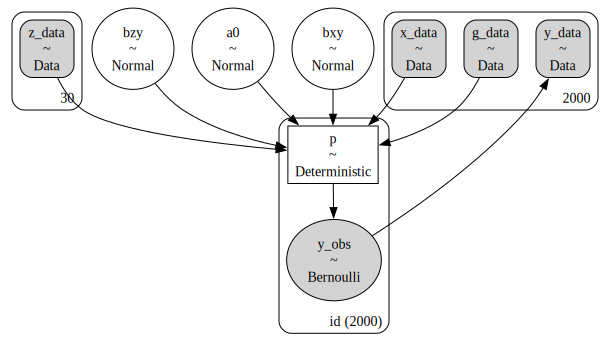

In [13]:
with pm.Model(coords=coords) as fixed_effects_model:
    x_data = pm.Data("x_data", x_obs)
    y_data = pm.Data("y_data", y_obs)
    g_data = pm.Data("g_data", g)
    z_data = pm.Data("z_data", z_obs)

    a0 = pm.Normal("a0", mu=0, sigma=10, dims="group")
    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)

    p = pm.Deterministic(
        "p", pm.math.invlogit(a0[g] + bxy * x_data + bzy * z_data[g_data]), dims="id"
    )
    pm.Bernoulli("y_obs", p, dims="id", observed=y_data)

pm.model_to_graphviz(naive_model)

In [14]:
with fixed_effects_model:
    idata_fixed_effects = pm.sample(
        tune=1_000,
        draws=1_000,
        chains=4,
        cores=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,1,0.30,15
,2000,0,0.30,31
,2000,0,0.29,15
,2000,0,0.28,15


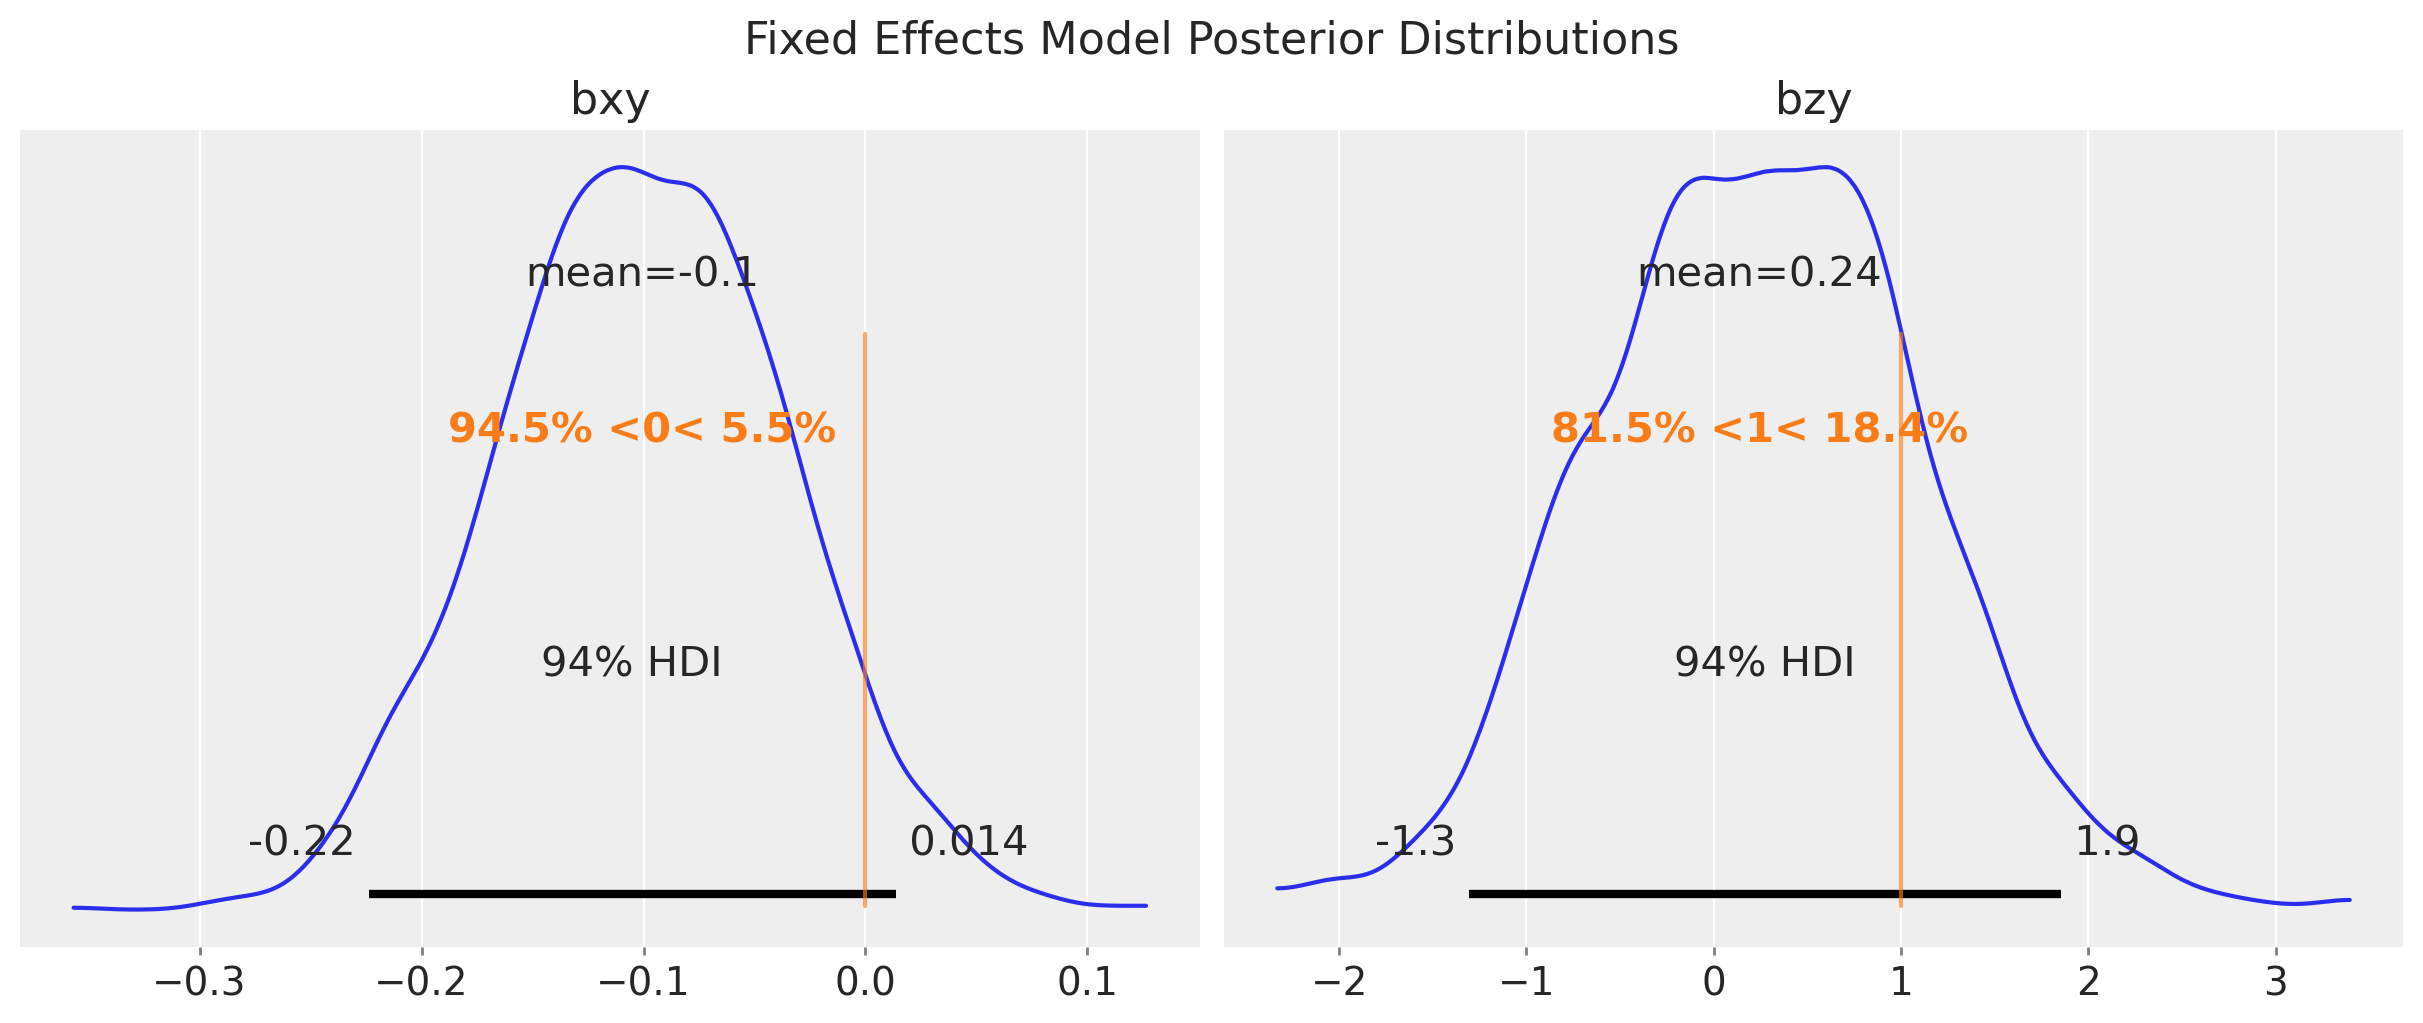

In [ ]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Fixed Effects Model Posterior Distributions", fontsize=16);

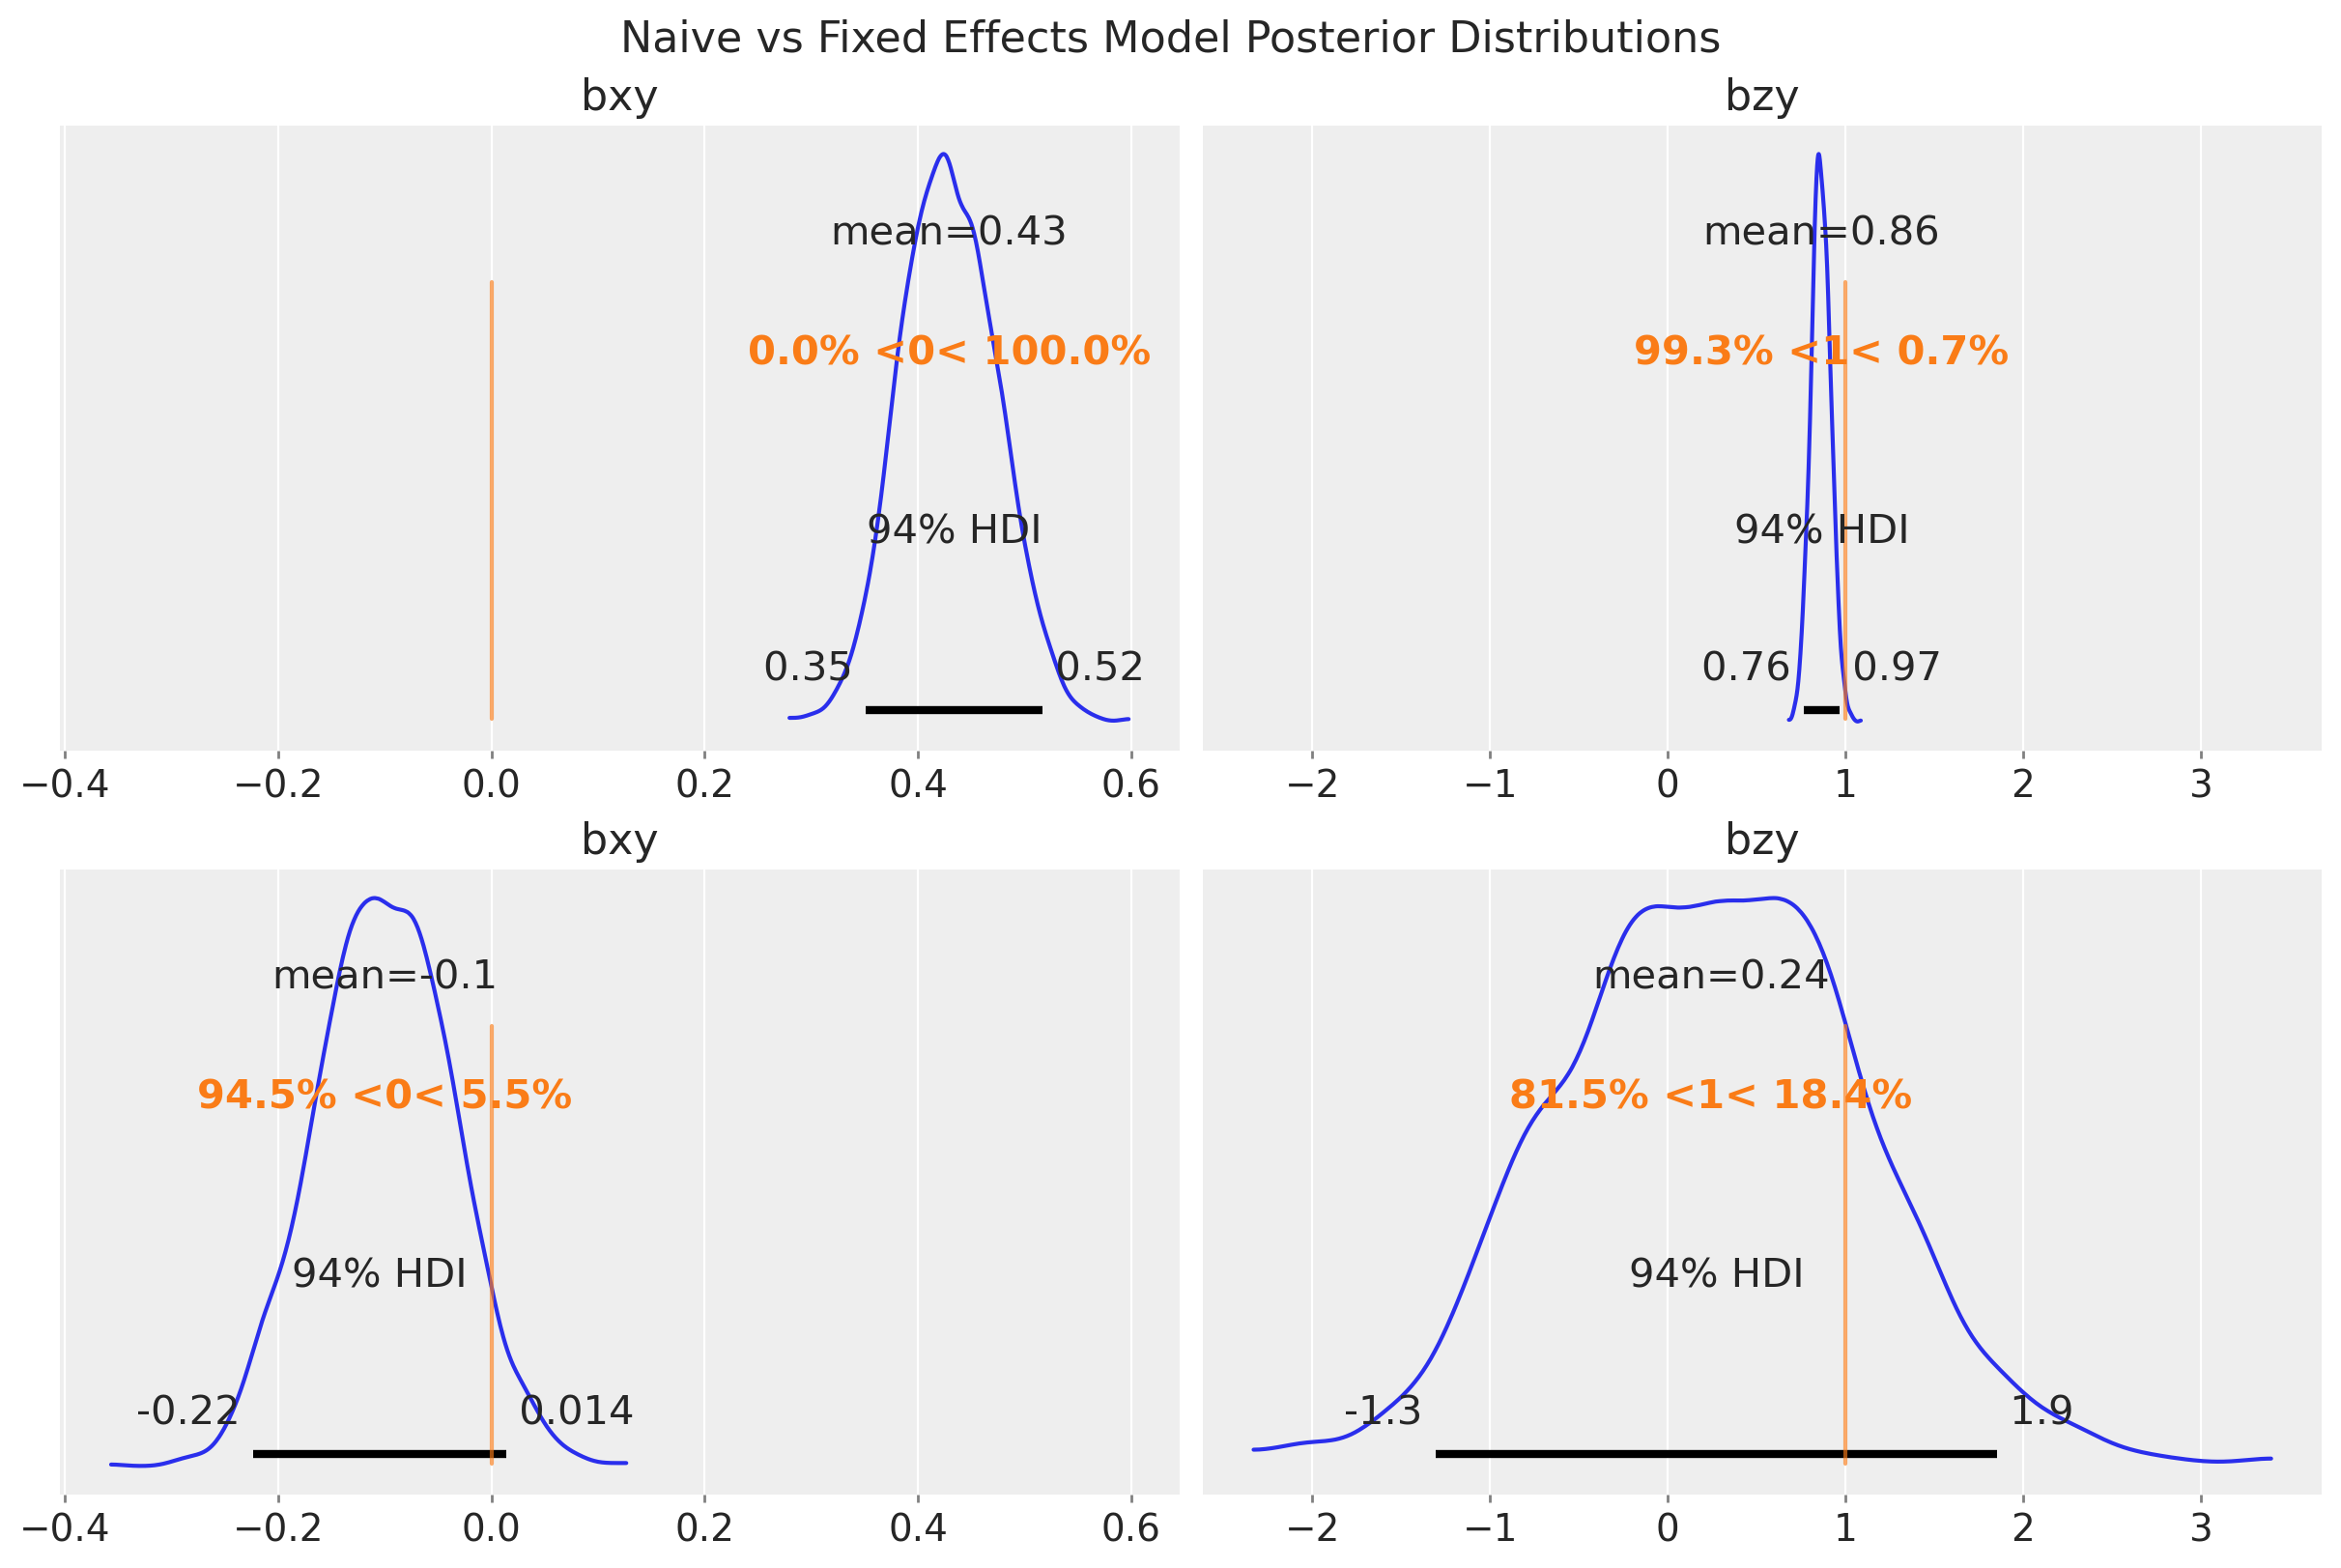

In [21]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12, 8),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["bxy", "bzy"],
    ref_val={
        "bxy": [{"ref_val": true_params["bxy"]}],
        "bzy": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

fig.suptitle("Naive vs Fixed Effects Model Posterior Distributions", fontsize=16);